# 第4章：从零实现GPT模型以生成文本

In [1]:
from importlib.metadata import version

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.8
torch version: 2.9.1
tiktoken version: 0.12.0


- 在本章中，我们实现一个类似GPT的大语言模型架构；下一章将重点训练这个大语言模型

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/01.webp" width="500px">

## 4.1 实现LLM架构

- 第一章讨论了像GPT和Llama这样的模型，它们按顺序生成单词，并且基于原始transformer架构的解码器部分
- 因此，这些大语言模型通常被称为"类解码器"大语言模型
- 与传统的深度学习模型相比，大语言模型更大，主要是由于它们拥有大量的参数，而不是代码量
- 我们将看到大语言模型架构中有许多元素是重复的

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/02.webp" width="400px">

- 在前面的章节中，为了便于说明，我们使用了较小的嵌入维度用于token输入和输出，确保它们能在一页上显示
- 在本章中，我们考虑类似于小型GPT-2模型的嵌入和模型大小
- 我们将具体编写最小的GPT-2模型（1.24亿参数）的架构，如Radford等人[Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)中所述（注意，初始报告将其列为1.17亿参数，但后来在模型权重仓库中进行了更正）
- 第六章将展示如何将预训练权重加载到我们的实现中，这将与3.45亿、7.62亿和15.42亿参数的模型大小兼容

- 1.24亿参数GPT-2模型的配置详情包括：

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

- 我们使用简短的变量名，以避免后续代码行过长
- `"vocab_size"` 表示词汇表大小为50,257个单词，由第二章讨论的BPE分词器支持
- `"context_length"` 表示模型的最大输入token数量，由第二章介绍的位置嵌入支持
- `"emb_dim"` 是token输入的嵌入大小，将每个输入token转换为768维向量
- `"n_heads"` 是第三章实现的多头注意力机制中的注意力头数
- `"n_layers"` 是模型内transformer块的数量，我们将在后续章节中实现
- `"drop_rate"` 是dropout机制的强度，在第三章中讨论过；0.1表示在训练期间丢弃10%的隐藏单元以减轻过拟合
- `"qkv_bias"` 决定多头注意力机制（来自第三章）中的`Linear`层在计算查询（Q）、键（K）和值（V）张量时是否应包含偏置向量；我们将禁用此选项，这是现代大语言模型的标准做法；但是，我们稍后在第五章中将OpenAI的预训练GPT-2权重加载到我们的重新实现中时会重新讨论这一点

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/03.webp" width="500px">

In [ ]:
# 导入PyTorch核心库
import torch  # PyTorch张量计算库，提供基础张量操作和自动微分功能
import torch.nn as nn  # PyTorch神经网络模块，包含各种层和模型基类


# 定义DummyGPTModel类：这是一个占位符GPT模型，用于演示GPT架构的整体结构
# 继承自nn.Module，这是PyTorch中所有神经网络模块的基类
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        # 调用父类nn.Module的初始化方法，确保模型正确注册为PyTorch模块
        super().__init__()
        
        # 创建token嵌入层：将词汇表中的每个token（单词）映射到高维向量空间
        # cfg["vocab_size"]: 词汇表大小，例如50257（GPT-2的词汇表大小）
        # cfg["emb_dim"]: 嵌入维度，例如768（每个token被转换为768维向量）
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        
        # 创建位置嵌入层：为序列中的每个位置分配一个可学习的嵌入向量
        # cfg["context_length"]: 上下文长度，例如1024（模型能处理的最大token数）
        # cfg["emb_dim"]: 嵌入维度，必须与token嵌入维度相同，以便相加
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        
        # 创建dropout层：在训练时随机将部分神经元输出置为0，防止过拟合
        # cfg["drop_rate"]: dropout率，例如0.1（表示10%的神经元会被随机置零）
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # 创建transformer块序列：这是GPT模型的核心，包含多层transformer块
        # 使用占位符DummyTransformerBlock，后续会被真正的TransformerBlock替换
        # cfg["n_layers"]: transformer块的数量，例如12（GPT-2 small有12层）
        # *[...] 语法用于解包列表，将多个块传递给Sequential
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # 创建最终层归一化：在输出层之前对特征进行归一化
        # 使用占位符DummyLayerNorm，后续会被真正的LayerNorm替换
        # cfg["emb_dim"]: 嵌入维度，用于指定归一化的特征维度
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        
        # 创建输出头：将模型内部表示转换为词汇表上的概率分布
        # cfg["emb_dim"]: 输入维度（嵌入维度）
        # cfg["vocab_size"]: 输出维度（词汇表大小）
        # bias=False: 不使用偏置项，这是GPT-2的设计选择
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        # 前向传播函数：定义数据如何通过模型
        
        # 获取输入张量的形状信息
        # batch_size: 批次大小（同时处理的样本数）
        # seq_len: 序列长度（每个样本的token数量）
        batch_size, seq_len = in_idx.shape
        
        # 将输入的token索引转换为嵌入向量
        # in_idx: 形状为[batch_size, seq_len]的整数张量，包含token的索引
        # 输出: 形状为[batch_size, seq_len, emb_dim]的浮点张量
        tok_embeds = self.tok_emb(in_idx)
        
        # 生成位置嵌入：为序列中的每个位置创建嵌入向量
        # torch.arange(seq_len): 创建[0, 1, 2, ..., seq_len-1]的位置索引
        # device=in_idx.device: 确保位置索引在与输入相同的设备上（CPU或GPU）
        # 输出: 形状为[seq_len, emb_dim]的位置嵌入，会自动广播到[batch_size, seq_len, emb_dim]
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        
        # 将token嵌入和位置嵌入相加：这是transformer架构的标准做法
        # 通过相加，模型同时获得token的语义信息和位置信息
        # 输出: 形状为[batch_size, seq_len, emb_dim]
        x = tok_embeds + pos_embeds
        
        # 应用dropout：在训练时随机置零部分神经元，防止过拟合
        # 在推理时（eval模式），dropout会自动关闭
        x = self.drop_emb(x)
        
        # 通过transformer块序列：这是模型的核心处理部分
        # 每个transformer块包含自注意力机制和前馈网络
        # 输出: 形状仍为[batch_size, seq_len, emb_dim]，但特征已被多层处理
        x = self.trf_blocks(x)
        
        # 应用最终层归一化：在输出之前对特征进行归一化
        # 这有助于稳定训练和提高模型性能
        x = self.final_norm(x)
        
        # 通过输出头：将内部表示转换为词汇表上的logits（未归一化的分数）
        # logits: 形状为[batch_size, seq_len, vocab_size]
        # 每个位置都有一个长度为vocab_size的向量，表示该位置预测每个token的分数
        logits = self.out_head(x)
        
        # 返回logits：这些分数可以通过softmax转换为概率分布
        # 概率最高的token就是模型预测的下一个token
        return logits


# 定义DummyTransformerBlock类：transformer块的占位符
# 这个类暂时不做任何处理，只是保持接口一致性，后续会被真正的TransformerBlock替换
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        # 调用父类初始化方法
        super().__init__()
        # 这是一个简单的占位符，不包含任何实际的层或参数

    def forward(self, x):
        # 前向传播：直接返回输入，不做任何变换
        # 这个占位符块用于在实现完整架构之前测试模型的基本结构
        return x


# 定义DummyLayerNorm类：层归一化的占位符
# 这个类暂时不做任何归一化处理，只是保持接口一致性，后续会被真正的LayerNorm替换
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        # 调用父类初始化方法
        super().__init__()
        # normalized_shape: 需要归一化的维度形状（通常是一个整数或元组）
        # eps: 防止除零的小常数（epsilon），在计算方差时添加到分母
        # 这些参数只是为了模拟LayerNorm的接口，实际不执行任何操作

    def forward(self, x):
        # 前向传播：直接返回输入，不做任何归一化
        # 这个占位符层用于在实现完整架构之前测试模型的基本结构
        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/04.webp?123" width="500px">

In [ ]:
# 导入tiktoken库：OpenAI开发的高性能BPE（字节对编码）分词器
# tiktoken是GPT模型使用的官方分词器，支持GPT-2、GPT-3、GPT-4等模型
import tiktoken

# 获取GPT-2的分词器：使用与GPT-2训练时相同的编码方式
# "gpt2"指定使用GPT-2的BPE编码，这确保了与预训练模型的一致性
# 返回一个编码器对象，可以将文本转换为token ID，或将token ID转换回文本
tokenizer = tiktoken.get_encoding("gpt2")

# 初始化批次列表：用于存储多个文本样本的编码结果
# 批次处理可以提高模型的计算效率，同时处理多个样本
batch = []

# 定义第一个文本样本：用于演示的英文句子
# 这个句子将被转换为token序列，然后输入到GPT模型
txt1 = "Every effort moves you"

# 定义第二个文本样本：另一个用于演示的英文句子
# 注意这个句子比第一个短，后续需要padding或处理不同长度
txt2 = "Every day holds a"

# 将第一个文本编码为token ID并转换为PyTorch张量
# tokenizer.encode(txt1): 将文本字符串转换为整数列表（token ID列表）
#   例如："Every effort moves you" -> [15496, 11, 314, 716]
# torch.tensor(...): 将Python列表转换为PyTorch张量，便于后续计算
#   输出形状: [seq_len1]，其中seq_len1是第一个文本的token数量
batch.append(torch.tensor(tokenizer.encode(txt1)))

# 将第二个文本编码为token ID并转换为PyTorch张量
# tokenizer.encode(txt2): 将文本字符串转换为整数列表
#   例如："Every day holds a" -> [15496, 1110, 6622, 257]
# torch.tensor(...): 转换为PyTorch张量
#   输出形状: [seq_len2]，其中seq_len2是第二个文本的token数量
batch.append(torch.tensor(tokenizer.encode(txt2)))

# 将批次列表堆叠成二维张量：将多个一维张量组合成一个批次
# torch.stack(batch, dim=0): 沿着第0维（批次维）堆叠张量
#   dim=0: 在第一个维度上堆叠，创建新的批次维度
#   输入: 两个形状为[seq_len1]和[seq_len2]的一维张量
#   输出: 形状为[2, max(seq_len1, seq_len2)]的二维张量
#   注意：如果序列长度不同，较短的序列会被padding（填充）到相同长度
#   最终形状: [batch_size, seq_len]，例如[2, 4]表示2个样本，每个4个token
batch = torch.stack(batch, dim=0)

# 打印批次张量：查看编码后的结果
# 输出示例: tensor([[6109, 3626, 6100,  345],
#                   [6109, 1110, 6622,  257]])
# 每一行代表一个文本样本的token ID序列
# 这些ID对应词汇表中的特定token，模型将使用这些ID进行前向传播
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


---

**注意**

- 如果您在Windows或Linux上运行此代码，上面的结果值可能如下所示：
    
```
Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)
```

- 由于这些只是随机数字，这不是需要担心的问题，您可以继续完成本章的其余部分而不会出现问题
- 这种差异的一个可能原因是`nn.Dropout`在不同操作系统上的行为不同，这取决于PyTorch的编译方式，如[PyTorch问题跟踪器](https://github.com/pytorch/pytorch/issues/121595)中讨论的那样

---

## 4.2 用层归一化标准化激活值

- 层归一化，也称为LayerNorm（[Ba et al. 2016](https://arxiv.org/abs/1607.06450)），将神经网络层的激活值中心化到均值为0，并将它们的方差归一化为1
- 这稳定了训练并能够更快地收敛到有效的权重
- 层归一化在transformer块内的多头注意力模块之前和之后都应用，我们稍后将实现；它也在最终输出层之前应用

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/05.webp" width="400px">

- 让我们通过将一个小输入样本传递到一个简单的神经网络层来了解层归一化的工作原理：

In [ ]:
# 设置随机种子：确保每次运行代码时生成的随机数相同，便于结果复现和调试
# 123是种子值，相同的种子会产生相同的随机数序列
torch.manual_seed(123)

# 创建批次示例：生成一个包含2个训练样本的批次，每个样本有5个特征维度
# torch.randn(2, 5): 从标准正态分布（均值为0，标准差为1）中随机采样
#   参数说明：
#   - 2: 批次大小（batch_size），表示同时处理2个样本
#   - 5: 特征维度（feature_dim），每个样本有5个特征
#   输出形状: [2, 5]，即2行5列的二维张量
#   每一行代表一个样本，每一列代表一个特征
batch_example = torch.randn(2, 5) 

# 定义神经网络层：使用Sequential容器将多个层按顺序组合
# nn.Sequential: 按顺序执行多个层的容器，数据会依次通过每个层
# nn.Linear(5, 6): 线性（全连接）层
#   参数说明：
#   - 5: 输入特征维度（in_features），接收5维输入
#   - 6: 输出特征维度（out_features），输出6维特征
#   功能：执行线性变换 y = xW^T + b，其中W是权重矩阵，b是偏置向量
#   权重矩阵形状: [6, 5]，偏置向量形状: [6]
# nn.ReLU(): 修正线性单元激活函数
#   功能：ReLU(x) = max(0, x)，将负值置为0，正值保持不变
#   作用：引入非线性，使网络能够学习复杂的模式
# 整体流程：输入[2, 5] -> Linear层 -> [2, 6] -> ReLU激活 -> [2, 6]
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())

# 前向传播：将批次数据通过神经网络层进行处理
# layer(batch_example): 调用layer的forward方法，执行前向传播
#   输入: batch_example，形状为[2, 5]
#   处理过程：
#     1. 通过Linear层：执行矩阵乘法 [2, 5] × [5, 6]^T = [2, 6]
#     2. 通过ReLU层：对每个元素应用ReLU函数，负值变为0
#   输出: out，形状为[2, 6]
#   含义：每个样本的5个特征被转换为6个新的特征表示
out = layer(batch_example)

# 打印输出结果：查看经过神经网络层处理后的数据
# 输出示例形状: [2, 6]，包含2个样本，每个样本6个特征
# 由于ReLU的作用，输出中的负值会被置为0
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- 让我们计算上面2个输入中每个输入的均值和方差：

In [ ]:
# 计算均值：对每个样本的特征维度计算平均值
# out.mean(dim=-1, keepdim=True): 沿着最后一个维度计算均值
#   参数说明：
#   - dim=-1: 指定计算均值的维度
#     -1表示最后一个维度，对于形状[2, 6]的张量，-1就是第1维（特征维）
#     即沿着特征维度（列方向）计算，对每个样本的6个特征求平均
#   - keepdim=True: 保持维度，使输出形状与输入兼容
#     如果keepdim=False，输出形状会是[2]（一维）
#     如果keepdim=True，输出形状是[2, 1]（二维，保持原始维度数）
#   输入: out，形状为[2, 6]（2个样本，每个6个特征）
#   计算过程：对每一行的6个特征值求平均
#     样本1: mean1 = (f1 + f2 + f3 + f4 + f5 + f6) / 6
#     样本2: mean2 = (f1 + f2 + f3 + f4 + f5 + f6) / 6
#   输出: mean，形状为[2, 1]
#     每一行包含对应样本的特征均值
#
#   具体示例说明"沿着最后一个维度计算均值"：
#   假设 out = [[1.0, 2.0, 3.0, 4.0, 5.0, 6.0],    # 样本1的6个特征
#               [2.0, 4.0, 6.0, 8.0, 10.0, 12.0]]  # 样本2的6个特征
#   形状: [2, 6]，其中：
#     - 第0维（dim=0）是批次维，有2个样本
#     - 第1维（dim=1，即dim=-1）是特征维，每个样本有6个特征
#   
#   当执行 out.mean(dim=-1, keepdim=True) 时：
#     - dim=-1 表示沿着最后一个维度（特征维，即dim=1）计算
#     - 对样本1: mean1 = (1.0 + 2.0 + 3.0 + 4.0 + 5.0 + 6.0) / 6 = 3.5
#     - 对样本2: mean2 = (2.0 + 4.0 + 6.0 + 8.0 + 10.0 + 12.0) / 6 = 7.0
#     - 输出: [[3.5], [7.0]]，形状为[2, 1]
#   
#   如果使用 dim=0（沿着批次维计算），结果会不同：
#     - 对每个特征位置: mean_feat = (样本1的值 + 样本2的值) / 2
#     - 输出: [[1.5, 3.0, 4.5, 6.0, 7.5, 9.0]]，形状为[1, 6]
#     - 这计算的是跨样本的每个特征的平均值，而不是每个样本的特征平均值
mean = out.mean(dim=-1, keepdim=True)

# 计算方差：对每个样本的特征维度计算方差
# out.var(dim=-1, keepdim=True): 沿着最后一个维度计算方差
#   参数说明：
#   - dim=-1: 指定计算方差的维度（与mean相同，沿着特征维度）
#   - keepdim=True: 保持维度，输出形状为[2, 1]
#   输入: out，形状为[2, 6]
#   计算过程：对每一行的6个特征值计算方差
#     方差公式: var = Σ(xi - mean)² / n
#     样本1: var1 = Σ(fi - mean1)² / 6
#     样本2: var2 = Σ(fi - mean2)² / 6
#   输出: var，形状为[2, 1]
#     每一行包含对应样本的特征方差
#   注意：默认使用无偏估计（分母为n-1），可以通过unbiased参数控制
var = out.var(dim=-1, keepdim=True)

# 打印均值结果：查看每个样本的特征均值
# 输出形状: [2, 1]，包含2个标量值，分别对应2个样本的均值
print("Mean:\n", mean)

# 打印方差结果：查看每个样本的特征方差
# 输出形状: [2, 1]，包含2个标量值，分别对应2个样本的方差
# 方差反映了特征值的分散程度，方差越大说明特征值分布越分散
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- 归一化独立应用于两个输入（行）中的每一个；使用dim=-1在最后一个维度（在这种情况下是特征维度）上应用计算，而不是行维度

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/06.webp" width="400px">

- 减去均值并除以方差的平方根（标准差）将输入中心化，使其在列（特征）维度上的均值为0，方差为1：

In [ ]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 每个输入都中心化到0，单位方差为1；为了提高可读性，我们可以禁用PyTorch的科学计数法：

In [ ]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 上面，我们归一化了每个输入的特征
- 现在，使用相同的想法，我们可以实现一个`LayerNorm`类：

In [ ]:
# 定义LayerNorm类：实现层归一化（Layer Normalization）操作
# 层归一化是transformer架构中的关键组件，用于稳定训练和加速收敛
# 继承自nn.Module，使其成为PyTorch的神经网络模块
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        # 调用父类nn.Module的初始化方法，确保模块正确注册
        super().__init__()
        
        # 设置epsilon（ε）值：一个很小的常数，用于防止除零错误
        # 当计算方差时，如果方差为0，sqrt(var + eps)可以避免除以0的情况
        # 1e-5 = 0.00001，这是一个常用的默认值
        self.eps = 1e-5
        
        # 创建可学习的缩放参数（scale parameter）：用于缩放归一化后的特征
        # nn.Parameter: 将张量注册为模型参数，使其在训练过程中可以被优化
        # torch.ones(emb_dim): 创建形状为[emb_dim]的全1张量作为初始值
        #   初始值为1意味着初始时缩放操作不改变数值（乘以1）
        # emb_dim: 嵌入维度，例如768，表示每个特征向量的维度
        # 这个参数允许模型学习最适合数据的缩放因子
        self.scale = nn.Parameter(torch.ones(emb_dim))
        
        # 创建可学习的偏移参数（shift parameter）：用于偏移归一化后的特征
        # nn.Parameter: 将张量注册为模型参数
        # torch.zeros(emb_dim): 创建形状为[emb_dim]的全0张量作为初始值
        #   初始值为0意味着初始时偏移操作不改变数值（加上0）
        # 这个参数允许模型学习最适合数据的偏移量
        # scale和shift的组合使得模型可以学习恢复归一化可能丢失的信息
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        # 前向传播函数：执行层归一化的完整计算过程
        
        # 步骤1：计算均值
        # 沿着最后一个维度（特征维度）计算每个样本的均值
        # x.mean(dim=-1, keepdim=True):
        #   - dim=-1: 沿着最后一个维度计算（对于形状[batch, seq_len, emb_dim]，就是emb_dim维度）
        #   - keepdim=True: 保持维度，输出形状为[batch, seq_len, 1]
        #   例如：如果x形状是[2, 4, 768]，mean形状是[2, 4, 1]
        #   对每个位置的768维特征向量，计算其768个元素的平均值
        mean = x.mean(dim=-1, keepdim=True)
        
        # 步骤2：计算方差
        # 沿着最后一个维度（特征维度）计算每个样本的方差
        # x.var(dim=-1, keepdim=True, unbiased=False):
        #   - dim=-1: 沿着最后一个维度计算
        #   - keepdim=True: 保持维度，输出形状为[batch, seq_len, 1]
        #   - unbiased=False: 使用有偏方差估计（分母为n，而不是n-1）
        #     这是GPT-2使用的设置，为了与预训练权重兼容
        #   方差公式: var = Σ(xi - mean)² / n
        #   例如：如果x形状是[2, 4, 768]，var形状是[2, 4, 1]
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        
        # 步骤3：归一化
        # 执行标准归一化：将特征中心化（减去均值）并标准化（除以标准差）
        # (x - mean): 中心化操作，将每个特征向量减去其均值，使均值为0
        # torch.sqrt(var + self.eps): 计算标准差（方差的平方根）
        #   - var + self.eps: 添加epsilon防止方差为0时出现除零错误
        #   - sqrt(...): 计算标准差，用于标准化
        # 归一化公式: norm_x = (x - mean) / sqrt(var + eps)
        #   结果：归一化后的特征均值为0，标准差为1
        #   例如：如果x形状是[2, 4, 768]，norm_x形状也是[2, 4, 768]
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        
        # 步骤4：应用可学习的缩放和偏移
        # 这是层归一化的关键创新：允许模型学习恢复归一化可能丢失的信息
        # self.scale * norm_x: 缩放操作，将归一化后的特征乘以可学习的缩放因子
        #   - scale形状: [emb_dim]，例如[768]
        #   - norm_x形状: [batch, seq_len, emb_dim]
        #   - 广播机制：scale会自动广播到每个位置和样本
        # + self.shift: 偏移操作，将缩放后的特征加上可学习的偏移量
        #   - shift形状: [emb_dim]，例如[768]
        #   - 同样通过广播机制应用到所有位置和样本
        # 最终公式: output = scale * norm_x + shift
        #   这允许模型学习：
        #   - 如果scale=1, shift=0：完全归一化（初始状态）
        #   - 如果scale和shift被训练调整：可以恢复归一化前的某些信息
        # 输出形状: [batch, seq_len, emb_dim]，与输入x相同
        return self.scale * norm_x + self.shift

**缩放和偏移**

- 请注意，除了通过减去均值和除以方差来执行归一化之外，我们还添加了两个可训练参数，一个`scale`参数和一个`shift`参数
- 初始的`scale`（乘以1）和`shift`（加上0）值没有任何效果；但是，`scale`和`shift`是可训练参数，如果确定这样做会提高模型在训练任务上的性能，大语言模型会在训练期间自动调整它们
- 这允许模型学习最适合其处理数据的适当缩放和偏移
- 请注意，我们还在计算方差的平方根之前添加一个较小的值（`eps`）；这是为了避免如果方差为0时出现除零错误

**有偏方差**
- 在上面的方差计算中，设置`unbiased=False`意味着使用公式$\frac{\sum_i (x_i - \bar{x})^2}{n}$来计算方差，其中n是样本大小（这里是特征或列的数量）；此公式不包括贝塞尔校正（在分母中使用`n-1`），因此提供了方差的有偏估计
- 对于大语言模型，其中嵌入维度`n`非常大，使用n和`n-1`之间的差异可以忽略不计
- 但是，GPT-2在归一化层中使用有偏方差进行训练，这就是为什么我们也采用此设置以与稍后章节中加载的预训练权重兼容

- 现在让我们在实践中尝试`LayerNorm`：

In [ ]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [12]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/07.webp" width="400px">

## 4.3 使用GELU激活函数实现前馈神经网络

- 在本节中，我们实现一个小的神经网络子模块，它用作大语言模型中transformer块的一部分
- 我们从激活函数开始
- 在深度学习中，ReLU（修正线性单元）激活函数由于其简单性和在各种神经网络架构中的有效性而被广泛使用
- 在大语言模型中，除了传统的ReLU之外，还使用各种其他类型的激活函数；两个值得注意的例子是GELU（高斯误差线性单元）和SwiGLU（Swish门控线性单元）
- GELU和SwiGLU是更复杂的平滑激活函数，分别结合了高斯和sigmoid门控线性单元，为深度学习模型提供更好的性能，这与ReLU的简单分段线性函数不同

- GELU（高斯误差线性单元，[Hendrycks 和 Gimpel 2016](https://arxiv.org/abs/1606.08415)）可以通过多种方式实现；其精确定义为：GELU(x)=x⋅Φ(x)，其中Φ(x)是标准正态分布的累积分布函数。
- 在实际中，通常会采用一种计算更高效的近似形式进行实现，即：$\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$（最初的GPT-2模型也是用此近似公式训练的）


In [13]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

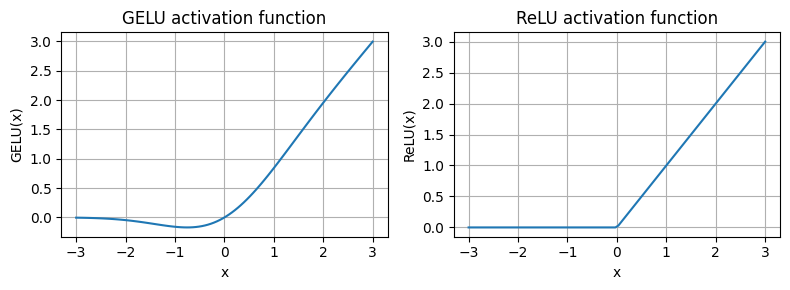

In [ ]:
# 导入matplotlib绘图库：用于创建数据可视化图表
# pyplot是matplotlib的接口，提供了类似MATLAB的绘图功能
import matplotlib.pyplot as plt

# 实例化激活函数对象：创建GELU和ReLU激活函数的实例
# GELU(): 创建自定义的GELU激活函数实例（之前定义的类）
# nn.ReLU(): 创建PyTorch内置的ReLU激活函数实例
# 这两个对象将被用于计算不同输入值对应的激活函数输出
gelu, relu = GELU(), nn.ReLU()

# 生成样本数据：创建用于绘制激活函数图像的输入数据
# torch.linspace(-3, 3, 100): 在-3到3之间均匀生成100个点
#   参数说明：
#   - -3: 起始值
#   - 3: 结束值
#   - 100: 点的数量
#   输出: 形状为[100]的一维张量，包含[-3.0, -2.94, -2.88, ..., 2.88, 2.94, 3.0]
#   这些点将作为激活函数的输入值，用于观察函数在不同输入下的行为
x = torch.linspace(-3, 3, 100)

# 计算激活函数的输出：对输入数据应用GELU和ReLU激活函数
# gelu(x): 将输入x通过GELU激活函数，计算每个输入值对应的GELU输出
#   GELU是平滑的非线性函数，对负值也有非零梯度
# relu(x): 将输入x通过ReLU激活函数，计算每个输入值对应的ReLU输出
#   ReLU是分段线性函数，负值输出为0，正值直接输出
# 输出形状: y_gelu和y_relu都是形状为[100]的一维张量
#   每个元素对应x中相应位置的激活函数输出值
y_gelu, y_relu = gelu(x), relu(x)

# 创建图形窗口：设置整个图形的尺寸
# plt.figure(figsize=(8, 3)):
#   - figsize=(8, 3): 设置图形大小为8英寸宽、3英寸高
#   这个尺寸适合并排显示两个子图（GELU和ReLU）
plt.figure(figsize=(8, 3))

# 循环绘制两个激活函数的图像
# enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
#   - zip(...): 将输出数据和标签配对，[(y_gelu, "GELU"), (y_relu, "ReLU")]
#   - enumerate(..., 1): 从1开始计数，i的值将是1和2
#   这个循环会执行两次，分别绘制GELU和ReLU的图像
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    # 创建子图：在1行2列的布局中，选择第i个子图位置
    # plt.subplot(1, 2, i):
    #   - 1, 2: 创建1行2列的子图布局（共2个子图）
    #   - i: 当前子图的位置（1表示左图，2表示右图）
    #   第一次循环：i=1，创建左侧子图（用于GELU）
    #   第二次循环：i=2，创建右侧子图（用于ReLU）
    plt.subplot(1, 2, i)
    
    # 绘制函数曲线：在子图中绘制激活函数的图像
    # plt.plot(x, y):
    #   - x: x轴数据（输入值），形状[100]
    #   - y: y轴数据（激活函数输出），形状[100]
    #   绘制100个点连接成的曲线，展示激活函数在[-3, 3]区间内的形状
    #   注意：需要将PyTorch张量转换为numpy数组，matplotlib才能绘制
    #   （如果x和y是张量，matplotlib会自动处理转换）
    plt.plot(x, y)
    
    # 设置子图标题：为每个子图添加标题，说明这是哪个激活函数
    # f"{label} activation function": 使用f-string格式化字符串
    #   第一次循环：label="GELU"，标题为"GELU activation function"
    #   第二次循环：label="ReLU"，标题为"ReLU activation function"
    plt.title(f"{label} activation function")
    
    # 设置x轴标签：为x轴添加标签，说明这是输入值
    # "x": x轴的标签文本，表示输入值
    plt.xlabel("x")
    
    # 设置y轴标签：为y轴添加标签，说明这是激活函数的输出值
    # f"{label}(x)": 动态生成y轴标签
    #   第一次循环：y轴标签为"GELU(x)"
    #   第二次循环：y轴标签为"ReLU(x)"
    #   这清楚地表明y轴表示激活函数对输入x的输出
    plt.ylabel(f"{label}(x)")
    
    # 显示网格：在子图中显示网格线，便于读取数值
    # grid(True): 启用网格显示
    #   网格线帮助观察函数值，更容易看出GELU和ReLU的区别
    plt.grid(True)

# 调整子图布局：自动调整子图之间的间距，避免重叠
# plt.tight_layout(): 自动优化子图的间距和边距
#   确保两个子图的标题、标签等元素不会重叠或被截断
plt.tight_layout()

# 显示图形：在Jupyter Notebook中显示绘制好的图像
# plt.show(): 渲染并显示图形
#   在Jupyter Notebook中，这会直接在输出区域显示两个并排的激活函数图像
#   可以直观地比较GELU和ReLU的形状差异：
#   - ReLU: 负值部分为0（水平线），正值部分为直线y=x
#   - GELU: 平滑的S型曲线，负值部分也有非零输出
plt.show()

- 正如我们所看到的，ReLU是一个分段线性函数，如果输入为正，则直接输出输入；否则，它输出零
- GELU是一个平滑的非线性函数，它近似ReLU，但对于负值具有非零梯度（除了大约-0.75处）

- 接下来，让我们实现小的神经网络模块`FeedForward`，我们稍后将在大语言模型的transformer块中使用它：

In [ ]:
# 定义FeedForward类：实现前馈神经网络（Feed Forward Network，FFN）
# 这是transformer块中的一个关键组件，用于对注意力机制输出的特征进行非线性变换
# 前馈网络通常采用"扩展-压缩"的结构：先扩展到更大维度，再压缩回原始维度
# 继承自nn.Module，使其成为PyTorch的神经网络模块
class FeedForward(nn.Module):
    def __init__(self, cfg):
        # 调用父类nn.Module的初始化方法，确保模块正确注册
        super().__init__()
        
        # 定义前馈网络的层序列：使用Sequential容器按顺序组合多个层
        # nn.Sequential: 按顺序执行多个层的容器，数据会依次通过每个层
        self.layers = nn.Sequential(
            # 第一层：扩展层（Expansion Layer）
            # 将嵌入维度扩展到4倍，这是GPT架构的标准设计
            # nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]):
            #   - 输入维度: cfg["emb_dim"]，例如768
            #   - 输出维度: 4 * cfg["emb_dim"]，例如768 * 4 = 3072
            #   功能：执行线性变换 y = xW^T + b
            #   权重矩阵形状: [3072, 768]，偏置向量形状: [3072]
            #   作用：将特征从768维扩展到3072维，增加模型的表达能力
            #   这种扩展设计允许模型学习更复杂的特征表示
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            
            # 激活函数层：应用GELU激活函数引入非线性
            # GELU(): 高斯误差线性单元激活函数
            #   功能：GELU(x) ≈ 0.5 * x * (1 + tanh(√(2/π) * (x + 0.044715 * x³)))
            #   特点：平滑的非线性函数，对负值也有非零梯度
            #   作用：引入非线性变换，使网络能够学习复杂的模式
            #   在GPT-2中，GELU比ReLU表现更好，因为它对负值也有响应
            #   输入形状: [batch, seq_len, 3072]
            #   输出形状: [batch, seq_len, 3072]（形状不变，只是值被激活函数变换）
            GELU(),
            
            # 第二层：压缩层（Compression Layer）
            # 将扩展后的维度压缩回原始的嵌入维度
            # nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]):
            #   - 输入维度: 4 * cfg["emb_dim"]，例如3072
            #   - 输出维度: cfg["emb_dim"]，例如768
            #   功能：执行线性变换，将3072维特征压缩回768维
            #   权重矩阵形状: [768, 3072]，偏置向量形状: [768]
            #   作用：将扩展后的特征表示压缩回原始维度，保持输出形状与输入一致
            #   这种"扩展-压缩"结构允许模型在中间层学习更丰富的表示，然后压缩回原始维度
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )
        # 整体数据流：
        #   输入: [batch, seq_len, emb_dim] (例如 [2, 4, 768])
        #   -> 扩展层: [batch, seq_len, 4*emb_dim] (例如 [2, 4, 3072])
        #   -> GELU激活: [batch, seq_len, 4*emb_dim] (形状不变，值被激活)
        #   -> 压缩层: [batch, seq_len, emb_dim] (例如 [2, 4, 768])
        #   输出: [batch, seq_len, emb_dim] (与输入形状相同)

    def forward(self, x):
        # 前向传播函数：定义数据如何通过前馈网络
        
        # 将输入x通过层序列：依次通过扩展层、GELU激活、压缩层
        # self.layers(x): 调用Sequential容器的forward方法
        #   输入: x，形状为[batch, seq_len, emb_dim]
        #   处理过程：
        #     1. 通过第一层Linear：扩展维度 [batch, seq_len, emb_dim] -> [batch, seq_len, 4*emb_dim]
        #     2. 通过GELU：应用激活函数，形状不变
        #     3. 通过第二层Linear：压缩维度 [batch, seq_len, 4*emb_dim] -> [batch, seq_len, emb_dim]
        #   输出: 形状为[batch, seq_len, emb_dim]，与输入形状相同
        #   含义：对每个位置的嵌入向量进行非线性变换，增强特征表示能力
        return self.layers(x)

In [16]:
print(GPT_CONFIG_124M["emb_dim"])

768


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/09.webp?12" width="400px">

In [17]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/10.webp" width="400px">

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/11.webp" width="400px">

## 4.4 添加快捷连接

- 接下来，让我们讨论快捷连接背后的概念，也称为跳跃或残差连接
- 最初，快捷连接是在用于计算机视觉的深度网络（残差网络）中提出的，以缓解梯度消失问题
- 快捷连接为梯度通过网络创建了一条替代的较短路径
- 这是通过将一层的输出添加到后续层的输出来实现的，通常跳过中间的一层或多层
- 让我们用一个小的示例网络来说明这个想法：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/12.webp?123" width="400px">

- 在代码中，它看起来像这样：

In [ ]:
# 定义ExampleDeepNeuralNetwork类：用于演示快捷连接（残差连接）的示例网络
# 这个类展示了如何在深度神经网络中实现快捷连接，以及快捷连接如何帮助缓解梯度消失问题
# 继承自nn.Module，使其成为PyTorch的神经网络模块
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        # 调用父类nn.Module的初始化方法，确保模块正确注册
        super().__init__()
        
        # 保存快捷连接标志：决定是否在前向传播中使用快捷连接
        # use_shortcut: 布尔值，True表示使用快捷连接，False表示不使用
        # 这个参数允许我们比较有无快捷连接时的梯度流动情况
        self.use_shortcut = use_shortcut
        
        # 创建层列表：使用ModuleList存储多个神经网络层
        # nn.ModuleList: 用于存储多个模块的列表，与普通Python列表的区别是
        #   ModuleList中的模块会被正确注册为模型的子模块，参数可以被优化器找到
        # layer_sizes: 列表，例如[3, 3, 3, 3, 3, 1]，定义了每层的输入输出维度
        #   这个网络有5个隐藏层，每层都包含一个Linear层和一个GELU激活函数
        self.layers = nn.ModuleList([
            # 第1层：从layer_sizes[0]维映射到layer_sizes[1]维
            # nn.Sequential: 将Linear层和GELU激活函数组合在一起
            #   - nn.Linear: 线性变换层
            #   - GELU(): 激活函数，引入非线性
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            
            # 第2层：从layer_sizes[1]维映射到layer_sizes[2]维
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            
            # 第3层：从layer_sizes[2]维映射到layer_sizes[3]维
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            
            # 第4层：从layer_sizes[3]维映射到layer_sizes[4]维
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            
            # 第5层：从layer_sizes[4]维映射到layer_sizes[5]维（输出层）
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        # 前向传播函数：定义数据如何通过网络，可选择性地应用快捷连接
        
        # 遍历每一层：依次通过网络的每一层
        # self.layers: ModuleList包含5个Sequential层
        # 每次循环处理一层，数据逐步向前传播
        for layer in self.layers:
            # 计算当前层的输出：将输入x通过当前层进行处理
            # layer(x): 调用当前层的forward方法
            #   layer是一个Sequential容器，包含Linear层和GELU激活函数
            #   输入: x，形状由layer_sizes决定
            #   输出: layer_output，形状为当前层的输出维度
            layer_output = layer(x)
            
            # 检查是否可以应用快捷连接：判断是否使用残差连接
            # self.use_shortcut: 检查是否启用了快捷连接功能
            # x.shape == layer_output.shape: 检查输入和输出形状是否相同
            #   快捷连接要求输入和输出形状相同，才能进行元素级相加
            #   如果形状不同，无法直接相加，只能使用普通的前向传播
            if self.use_shortcut and x.shape == layer_output.shape:
                # 应用快捷连接：将输入直接加到层输出上（残差连接）
                # x + layer_output: 元素级相加，这是残差连接的核心操作
                #   数学表示: output = x + F(x)，其中F(x)是当前层的变换
                #   作用：
                #     - 创建了从输入到输出的直接路径，梯度可以更容易地反向传播
                #     - 缓解梯度消失问题，使深层网络更容易训练
                #     - 允许网络学习残差（residual），即F(x) = output - x
                #   输出形状: 与x和layer_output相同
                x = x + layer_output
            else:
                # 不使用快捷连接：直接使用层的输出作为下一层的输入
                # 这是传统的前向传播方式，没有残差连接
                # 在深层网络中，这种方式可能导致梯度消失问题
                x = layer_output
        
        # 返回最终输出：经过所有层处理后的结果
        # 输出形状: [batch_size, layer_sizes[5]]，例如[1, 1]
        return x


# 定义print_gradients函数：用于打印模型中所有权重参数的梯度信息
# 这个函数用于分析梯度流动，比较有无快捷连接时的梯度大小
def print_gradients(model, x):
    # 前向传播：将输入数据通过模型，计算输出
    # model(x): 调用模型的forward方法
    #   x: 输入数据，形状由模型的第一层决定
    #   output: 模型的输出，形状由模型的最后一层决定
    #   在前向传播过程中，PyTorch会构建计算图，为后续的反向传播做准备
    output = model(x)
    
    # 创建目标值：用于计算损失函数的参考值
    # torch.tensor([[0.]]): 创建一个形状为[1, 1]的张量，值为0.0
    #   这个目标值用于计算均方误差损失
    #   形状[1, 1]表示1个样本，1个输出值
    target = torch.tensor([[0.]])

    # 计算损失：衡量模型输出与目标值之间的差异
    # nn.MSELoss(): 创建均方误差损失函数对象
    #   MSE公式: loss = mean((output - target)²)
    #   这个损失函数会计算输出和目标之间的平方差的平均值
    loss = nn.MSELoss()
    
    # 计算损失值：将损失函数应用到输出和目标上
    # loss(output, target): 计算均方误差
    #   如果output接近target（0），损失值会很小
    #   如果output远离target，损失值会很大
    #   返回一个标量张量，包含损失值
    loss = loss(output, target)
    
    # 反向传播：计算损失对模型参数的梯度
    # loss.backward(): 执行反向传播算法
    #   过程：
    #     1. 从损失值开始，沿着计算图反向传播
    #     2. 使用链式法则计算每个参数的梯度
    #     3. 将梯度存储在参数的.grad属性中
    #   注意：只有requires_grad=True的参数才会计算梯度
    #   这个操作会修改模型参数的.grad属性，但不会更新参数值本身
    loss.backward()

    # 遍历模型的所有参数：检查每个参数的梯度信息
    # model.named_parameters(): 返回模型的所有参数及其名称的迭代器
    #   例如：("layers.0.0.weight", Parameter(...)), ("layers.0.0.bias", Parameter(...)), ...
    #   每个参数都有一个名称（如"layers.0.0.weight"）和一个Parameter对象
    for name, param in model.named_parameters():
        # 只处理权重参数：跳过偏置参数，只关注权重矩阵的梯度
        # 'weight' in name: 检查参数名称中是否包含"weight"
        #   例如："layers.0.0.weight"包含"weight"，会被处理
        #   而"layers.0.0.bias"不包含"weight"，会被跳过
        if 'weight' in name:
            # 打印权重的平均绝对梯度：显示每个权重层的梯度大小
            # param.grad: 参数的梯度张量，形状与参数相同
            #   .abs(): 计算梯度的绝对值，因为梯度可能为正或负
            #   .mean(): 计算所有梯度值的平均值，得到一个标量
            #   .item(): 将标量张量转换为Python数值
            # 这个值反映了梯度的大小：
            #   - 值大：梯度流动良好，参数更新幅度大
            #   - 值小：可能存在梯度消失问题，参数更新幅度小
            # 通过比较有无快捷连接时的梯度大小，可以验证快捷连接对梯度流动的改善
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

- 让我们首先打印**没有**快捷连接的梯度值：

In [ ]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


- 接下来，让我们打印**有**快捷连接的梯度值：

In [ ]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


- 正如我们根据上面的输出所看到的，快捷连接防止梯度在早期层（朝向`layer.0`）中消失
- 接下来，当我们在实现transformer块时，将使用这个快捷连接的概念

## 4.5 在 Transformer 块中连接注意力层和线性层

- 在本节中，我们现在将之前的概念组合成一个所谓的transformer块
- transformer块将前一章的因果多头注意力模块与线性层、我们在前面部分实现的前馈神经网络相结合
- 此外，transformer块还使用dropout和快捷连接

In [ ]:
# 导入说明：如果本地没有 `previous_chapters.py` 文件，
# 可以从 `llms-from-scratch` PyPI 包中导入
# 详细信息请参见: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# 例如：
# from llms_from_scratch.ch03 import MultiHeadAttention

# 从 previous_chapters 模块导入 MultiHeadAttention 类
# MultiHeadAttention: 多头注意力机制，这是 transformer 架构的核心组件之一
#   在之前的章节中已经实现，这里直接导入使用
#   多头注意力允许模型同时关注序列的不同表示子空间
from previous_chapters import MultiHeadAttention


# 定义 TransformerBlock 类：实现 transformer 架构中的一个完整块
# 这是 GPT 模型的核心组件，包含自注意力机制和前馈网络，以及残差连接和层归一化
# 继承自 nn.Module，使其成为 PyTorch 的神经网络模块
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        # 调用父类 nn.Module 的初始化方法，确保模块正确注册
        super().__init__()
        
        # 创建多头注意力层：这是 transformer 块的第一部分
        # MultiHeadAttention: 实现自注意力机制，允许序列中的每个位置关注所有其他位置
        #   参数说明：
        #   - d_in=cfg["emb_dim"]: 输入嵌入维度，例如 768
        #   - d_out=cfg["emb_dim"]: 输出嵌入维度，与输入相同，保持维度一致
        #   - context_length=cfg["context_length"]: 上下文长度，例如 1024，定义最大序列长度
        #   - num_heads=cfg["n_heads"]: 注意力头的数量，例如 12，每个头关注不同的表示子空间
        #   - dropout=cfg["drop_rate"]: dropout 率，例如 0.1，用于防止过拟合
        #   - qkv_bias=cfg["qkv_bias"]: 是否在 Q、K、V 线性变换中使用偏置，布尔值
        #   输出形状: [batch_size, num_tokens, emb_dim]
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        
        # 创建前馈网络层：这是 transformer 块的第二部分
        # FeedForward: 实现前馈神经网络，对注意力输出进行非线性变换
        #   cfg: 配置字典，包含 emb_dim 等信息
        #   前馈网络采用"扩展-压缩"结构：先扩展到 4 倍维度，再压缩回原始维度
        #   输出形状: [batch_size, num_tokens, emb_dim]
        self.ff = FeedForward(cfg)
        
        # 创建第一个层归一化：用于注意力块之前的归一化
        # LayerNorm: 层归一化，对每个样本的特征维度进行归一化
        #   cfg["emb_dim"]: 嵌入维度，例如 768，指定需要归一化的特征维度
        #   层归一化有助于稳定训练，加速收敛
        #   在 GPT-2 架构中，层归一化放在注意力层之前（Pre-LN 结构）
        self.norm1 = LayerNorm(cfg["emb_dim"])
        
        # 创建第二个层归一化：用于前馈网络块之前的归一化
        # LayerNorm: 与前一个层归一化相同，但用于前馈网络部分
        #   cfg["emb_dim"]: 嵌入维度，必须与第一个层归一化相同
        #   每个 transformer 块有两个层归一化：一个用于注意力，一个用于前馈网络
        self.norm2 = LayerNorm(cfg["emb_dim"])
        
        # 创建残差连接的 dropout 层：用于残差连接后的正则化
        # nn.Dropout: dropout 层，在训练时随机将部分神经元输出置为 0
        #   cfg["drop_rate"]: dropout 率，例如 0.1，表示 10% 的神经元会被随机置零
        #   这个 dropout 应用于残差连接之后，有助于防止过拟合
        #   注意：在推理时（eval 模式），dropout 会自动关闭
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # 前向传播函数：定义数据如何通过 transformer 块
        # 输入: x，形状为 [batch_size, num_tokens, emb_dim]
        # 输出: 形状与输入相同，但特征已被注意力机制和前馈网络处理
        
        # ========== 第一部分：注意力块（带残差连接） ==========
        
        # 保存输入作为快捷连接的参考：用于残差连接
        # shortcut = x: 保存原始输入 x，后续会与注意力输出相加
        #   这是残差连接的关键：创建从输入到输出的直接路径
        #   形状: [batch_size, num_tokens, emb_dim]
        shortcut = x
        
        # 应用第一个层归一化：在注意力层之前进行归一化
        # self.norm1(x): 对输入进行层归一化
        #   归一化公式: (x - mean) / sqrt(var + eps) * scale + shift
        #   作用：
        #     - 稳定训练：归一化后的数据分布更稳定
        #     - 加速收敛：减少内部协变量偏移
        #   输出形状: [batch_size, num_tokens, emb_dim]，与输入相同
        x = self.norm1(x)
        
        # 通过多头注意力层：计算自注意力
        # self.att(x): 执行多头注意力计算
        #   过程：
        #     1. 将输入转换为 Q（查询）、K（键）、V（值）三个矩阵
        #     2. 计算注意力分数：attention = softmax(QK^T / sqrt(d_k))V
        #     3. 多头机制：将输入分成多个头，分别计算注意力，然后拼接
        #   输出形状: [batch_size, num_tokens, emb_dim]
        #   每个位置的输出是其他所有位置的加权和，权重由注意力分数决定
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        
        # 应用 dropout：在残差连接之前进行正则化
        # self.drop_shortcut(x): 随机将部分神经元输出置为 0
        #   在训练时，这有助于防止过拟合
        #   在推理时（eval 模式），dropout 会自动关闭，所有神经元都参与计算
        #   输出形状: [batch_size, num_tokens, emb_dim]
        x = self.drop_shortcut(x)
        
        # 应用残差连接：将原始输入加到注意力输出上
        # x + shortcut: 元素级相加，这是残差连接的核心操作
        #   数学表示: output = x + shortcut，其中 x 是注意力输出，shortcut 是原始输入
        #   作用：
        #     - 创建直接路径：梯度可以直接从输出流回输入，缓解梯度消失
        #     - 允许学习残差：网络学习的是残差（residual），即 F(x) = output - x
        #     - 稳定训练：即使注意力层学习不好，至少可以传递原始信息
        #   输出形状: [batch_size, num_tokens, emb_dim]
        x = x + shortcut  # Add the original input back

        # ========== 第二部分：前馈网络块（带残差连接） ==========
        
        # 保存当前状态作为快捷连接的参考：用于前馈网络的残差连接
        # shortcut = x: 保存注意力块的输出，作为前馈网络残差连接的参考
        #   这是第二个残差连接：从前馈网络的输入到输出
        #   形状: [batch_size, num_tokens, emb_dim]
        shortcut = x
        
        # 应用第二个层归一化：在前馈网络之前进行归一化
        # self.norm2(x): 对注意力块的输出进行层归一化
        #   与第一个层归一化相同，但应用于不同的数据流
        #   输出形状: [batch_size, num_tokens, emb_dim]
        x = self.norm2(x)
        
        # 通过前馈网络层：执行非线性变换
        # self.ff(x): 执行前馈网络计算
        #   过程：
        #     1. 扩展层：将嵌入维度扩展到 4 倍（例如 768 → 3072）
        #     2. GELU 激活：应用 GELU 激活函数引入非线性
        #     3. 压缩层：将维度压缩回原始大小（例如 3072 → 768）
        #   输出形状: [batch_size, num_tokens, emb_dim]
        #   前馈网络对每个位置独立处理，不涉及位置之间的交互
        x = self.ff(x)
        
        # 应用 dropout：在残差连接之前进行正则化
        # self.drop_shortcut(x): 与前一个 dropout 相同，用于防止过拟合
        #   输出形状: [batch_size, num_tokens, emb_dim]
        x = self.drop_shortcut(x)
        
        # 应用残差连接：将前馈网络的输入加到输出上
        # x + shortcut: 元素级相加，第二个残差连接
        #   数学表示: output = x + shortcut，其中 x 是前馈网络输出，shortcut 是前馈网络输入
        #   作用：与前一个残差连接相同，创建直接路径，缓解梯度消失
        #   输出形状: [batch_size, num_tokens, emb_dim]
        x = x + shortcut  # Add the original input back

        # 返回最终输出：经过注意力机制和前馈网络处理后的结果
        # 输出形状: [batch_size, num_tokens, emb_dim]，与输入相同
        # 每个位置的嵌入向量都包含了：
        #   - 来自注意力机制的其他位置信息
        #   - 来自前馈网络的非线性变换
        #   - 来自残差连接的原始信息
        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" width="400px">

- 假设我们有2个输入样本，每个样本有4个token，其中每个token是一个768维嵌入向量；然后这个transformer块应用自注意力，接着是线性层，以产生相似大小的输出
- 您可以将输出视为我们在前一章讨论的上下文向量的增强版本

In [ ]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/14.webp?1" width="400px">

## 4.6 编写GPT模型代码

- 我们快完成了：现在让我们将transformer块插入到我们在本章开始时编码的架构中，以便获得可用的GPT架构
- 请注意，transformer块被重复多次；对于最小的1.24亿参数GPT-2模型，我们重复12次：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/15.webp" width="400px">

- 相应的代码实现，其中`cfg["n_layers"] = 12`：

In [ ]:
# 定义 GPTModel 类：实现完整的 GPT（Generative Pre-trained Transformer）模型
# 这是 GPT 架构的完整实现，包含嵌入层、transformer 块序列和输出层
# 继承自 nn.Module，使其成为 PyTorch 的神经网络模块
class GPTModel(nn.Module):
    def __init__(self, cfg):
        # 调用父类 nn.Module 的初始化方法，确保模块正确注册
        super().__init__()
        
        # 创建 token 嵌入层：将词汇表中的每个 token 映射到高维向量空间
        # nn.Embedding: 嵌入层，将离散的 token ID 转换为连续的向量表示
        #   cfg["vocab_size"]: 词汇表大小，例如 50257（GPT-2 的词汇表大小）
        #   cfg["emb_dim"]: 嵌入维度，例如 768（每个 token 被转换为 768 维向量）
        #   权重矩阵形状: [vocab_size, emb_dim]，例如 [50257, 768]
        #   功能：将整数索引（token ID）转换为密集的向量表示
        #   例如：token ID 1234 -> [0.23, -0.45, 0.67, ..., 0.12]（768 维向量）
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        
        # 创建位置嵌入层：为序列中的每个位置分配一个可学习的嵌入向量
        # nn.Embedding: 位置嵌入层，将位置索引转换为向量表示
        #   cfg["context_length"]: 上下文长度，例如 1024（模型能处理的最大 token 数）
        #   cfg["emb_dim"]: 嵌入维度，必须与 token 嵌入维度相同，以便相加
        #   权重矩阵形状: [context_length, emb_dim]，例如 [1024, 768]
        #   功能：为序列中的每个位置（0, 1, 2, ..., context_length-1）创建位置向量
        #   位置嵌入允许模型理解 token 在序列中的位置信息
        #   例如：位置 0 -> [0.1, -0.2, 0.3, ..., 0.4]（768 维向量）
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        
        # 创建嵌入层的 dropout：在嵌入层之后进行正则化
        # nn.Dropout: dropout 层，在训练时随机将部分神经元输出置为 0
        #   cfg["drop_rate"]: dropout 率，例如 0.1（表示 10% 的神经元会被随机置零）
        #   这个 dropout 应用于 token 嵌入和位置嵌入相加之后
        #   作用：防止过拟合，提高模型的泛化能力
        #   注意：在推理时（eval 模式），dropout 会自动关闭
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # 创建 transformer 块序列：这是 GPT 模型的核心，包含多层 transformer 块
        # nn.Sequential: 按顺序执行多个模块的容器，数据会依次通过每个块
        #   *[...] 语法：解包列表，将多个 TransformerBlock 传递给 Sequential
        #   TransformerBlock(cfg): 创建 transformer 块，包含注意力机制和前馈网络
        #   range(cfg["n_layers"]): 创建 n_layers 个 transformer 块
        #     cfg["n_layers"]: transformer 块的数量，例如 12（GPT-2 small 有 12 层）
        #   整体结构：输入 -> Block1 -> Block2 -> ... -> BlockN -> 输出
        #   每个 transformer 块都会对输入进行注意力计算和非线性变换
        #   输出形状: [batch_size, num_tokens, emb_dim]，与输入形状相同
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # 创建最终层归一化：在输出层之前对特征进行归一化
        # LayerNorm: 层归一化，对每个样本的特征维度进行归一化
        #   cfg["emb_dim"]: 嵌入维度，例如 768，指定需要归一化的特征维度
        #   层归一化有助于稳定训练，加速收敛
        #   在 GPT-2 架构中，最终层归一化放在输出头之前
        #   输出形状: [batch_size, num_tokens, emb_dim]，与输入形状相同
        self.final_norm = LayerNorm(cfg["emb_dim"])
        
        # 创建输出头：将模型内部表示转换为词汇表上的 logits（未归一化的分数）
        # nn.Linear: 线性（全连接）层，执行线性变换
        #   cfg["emb_dim"]: 输入维度（嵌入维度），例如 768
        #   cfg["vocab_size"]: 输出维度（词汇表大小），例如 50257
        #   bias=False: 不使用偏置项，这是 GPT-2 的设计选择
        #   权重矩阵形状: [vocab_size, emb_dim]，例如 [50257, 768]
        #   功能：将每个位置的嵌入向量转换为词汇表上的分数
        #   输出 logits 形状: [batch_size, num_tokens, vocab_size]
        #   每个位置的 logits 表示该位置预测每个 token 的分数
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        # 前向传播函数：定义数据如何通过 GPT 模型
        # 输入: in_idx，形状为 [batch_size, seq_len] 的整数张量，包含 token 的索引
        # 输出: logits，形状为 [batch_size, seq_len, vocab_size] 的浮点张量
        
        # 获取输入张量的形状信息：提取批次大小和序列长度
        # in_idx.shape: 获取输入张量的形状，例如 (2, 1024)
        #   batch_size: 批次大小（同时处理的样本数），例如 2
        #   seq_len: 序列长度（每个样本的 token 数量），例如 1024
        #   这些信息用于后续的位置嵌入生成
        batch_size, seq_len = in_idx.shape
        
        # 将输入的 token 索引转换为嵌入向量
        # self.tok_emb(in_idx): 通过 token 嵌入层将 token ID 转换为向量
        #   in_idx: 形状为 [batch_size, seq_len] 的整数张量
        #     例如：[[1234, 5678, 9012, ...], [3456, 7890, 1234, ...]]
        #   输出: tok_embeds，形状为 [batch_size, seq_len, emb_dim] 的浮点张量
        #     例如：[[[0.23, -0.45, ...], [0.67, 0.12, ...], ...], ...]
        #   每个 token ID 被转换为一个 emb_dim 维的向量
        tok_embeds = self.tok_emb(in_idx)
        
        # 生成位置嵌入：为序列中的每个位置创建嵌入向量
        # self.pos_emb(torch.arange(seq_len, device=in_idx.device)):
        #   torch.arange(seq_len): 创建位置索引序列 [0, 1, 2, ..., seq_len-1]
        #     例如：如果 seq_len=1024，则创建 [0, 1, 2, ..., 1023]
        #   device=in_idx.device: 确保位置索引在与输入相同的设备上（CPU 或 GPU）
        #     这很重要，因为嵌入层必须在与输入相同的设备上
        #   输出: pos_embeds，形状为 [seq_len, emb_dim] 的位置嵌入
        #     例如：[[0.1, -0.2, ...], [0.3, 0.4, ...], ..., [0.5, -0.1, ...]]
        #   这个位置嵌入会自动广播到 [batch_size, seq_len, emb_dim]
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        
        # 将 token 嵌入和位置嵌入相加：这是 transformer 架构的标准做法
        # tok_embeds + pos_embeds: 元素级相加，将位置信息注入到 token 嵌入中
        #   通过相加，模型同时获得：
        #     - token 的语义信息（来自 token 嵌入）
        #     - token 的位置信息（来自位置嵌入）
        #   输出: x，形状为 [batch_size, seq_len, emb_dim]
        #   例如：如果 tok_embeds[0,0] = [0.23, -0.45, ...]，pos_embeds[0] = [0.1, -0.2, ...]
        #   则 x[0,0] = [0.33, -0.65, ...]（对应元素相加）
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        
        # 应用嵌入层的 dropout：在进入 transformer 块之前进行正则化
        # self.drop_emb(x): 随机将部分嵌入向量的元素置为 0
        #   在训练时，这有助于防止过拟合
        #   在推理时（eval 模式），dropout 会自动关闭，所有元素都参与计算
        #   输出形状: [batch_size, seq_len, emb_dim]，与输入相同
        x = self.drop_emb(x)
        
        # 通过 transformer 块序列：这是模型的核心处理部分
        # self.trf_blocks(x): 依次通过所有 transformer 块
        #   每个 transformer 块包含：
        #     - 自注意力机制：允许每个位置关注所有其他位置
        #     - 前馈网络：对注意力输出进行非线性变换
        #     - 残差连接：缓解梯度消失问题
        #     - 层归一化：稳定训练
        #   数据流：x -> Block1 -> Block2 -> ... -> BlockN -> x
        #   输出形状: [batch_size, seq_len, emb_dim]，与输入形状相同
        #   但特征已被多层 transformer 块处理，包含了丰富的上下文信息
        x = self.trf_blocks(x)
        
        # 应用最终层归一化：在输出之前对特征进行归一化
        # self.final_norm(x): 对 transformer 块的输出进行层归一化
        #   归一化公式: (x - mean) / sqrt(var + eps) * scale + shift
        #   作用：
        #     - 稳定训练：归一化后的数据分布更稳定
        #     - 加速收敛：减少内部协变量偏移
        #   输出形状: [batch_size, seq_len, emb_dim]，与输入相同
        x = self.final_norm(x)
        
        # 通过输出头：将内部表示转换为词汇表上的 logits
        # self.out_head(x): 将每个位置的嵌入向量转换为词汇表上的分数
        #   输入: x，形状为 [batch_size, seq_len, emb_dim]
        #   处理：对每个位置的 emb_dim 维向量执行线性变换
        #   输出: logits，形状为 [batch_size, seq_len, vocab_size]
        #     例如：如果 batch_size=2, seq_len=1024, vocab_size=50257
        #     则 logits 形状为 [2, 1024, 50257]
        #   每个位置的 logits 是一个长度为 vocab_size 的向量
        #   表示该位置预测词汇表中每个 token 的分数（未归一化）
        #   这些分数可以通过 softmax 转换为概率分布
        logits = self.out_head(x)
        
        # 返回 logits：这些分数用于预测下一个 token
        # logits: 形状为 [batch_size, seq_len, vocab_size] 的浮点张量
        #   每个位置的 logits 表示该位置预测每个 token 的分数
        #   概率最高的 token 就是模型预测的下一个 token
        #   在训练时，这些 logits 会与真实标签计算交叉熵损失
        #   在推理时，这些 logits 会通过 softmax 转换为概率，然后采样生成文本
        return logits

- 使用1.24亿参数模型的配置，我们现在可以用随机初始权重实例化这个GPT模型，如下所示：

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


- 我们将在下一章训练这个模型
- 但是，关于其大小的快速说明：我们之前将其称为1.24亿参数模型；我们可以按以下方式再次检查这个数字：

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


- 正如我们在上面看到的，这个模型有1.63亿，而不是1.24亿参数；为什么？
- 在原始GPT-2论文中，研究人员应用了权重绑定，这意味着他们重用token嵌入层（`tok_emb`）作为输出层，这意味着设置`self.out_head.weight = self.tok_emb.weight`
- token嵌入层将50,257维的独热编码输入token投影到768维嵌入表示
- 输出层将768维嵌入投影回50,257维表示，以便我们可以将这些转换回单词（下一节将详细介绍）
- 因此，嵌入层和输出层具有相同数量的权重参数，正如我们可以根据它们权重矩阵的形状所看到的
- 但是，关于其大小的快速说明：我们之前将其称为1.24亿参数模型；我们可以按以下方式再次检查这个数字：

In [ ]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


- 在原始GPT-2论文中，研究人员重用了token嵌入矩阵作为输出矩阵
- 相应地，如果我们减去输出层的参数数量，我们将得到一个1.24亿参数模型：

In [ ]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


- 在实践中，我发现训练没有权重绑定的模型更容易，这就是为什么我们没有在这里实现它
- 但是，我们稍后在第五章加载预训练权重时会重新讨论并应用这个权重绑定的想法
- 最后，我们可以按以下方式计算模型的内存需求，这可能是一个有用的参考点：

In [ ]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


- 练习：您可以尝试以下其他配置，这些配置也在[GPT-2论文](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=dOad5HoAAAAJ&citation_for_view=dOad5HoAAAAJ:YsMSGLbcyi4C)中引用。

    - **GPT2-small**（我们已经实现的1.24亿配置）：
        - "emb_dim" = 768
        - "n_layers" = 12
        - "n_heads" = 12

    - **GPT2-medium:**
        - "emb_dim" = 1024
        - "n_layers" = 24
        - "n_heads" = 16
    
    - **GPT2-large:**
        - "emb_dim" = 1280
        - "n_layers" = 36
        - "n_heads" = 20
    
    - **GPT2-XL:**
        - "emb_dim" = 1600
        - "n_layers" = 48
        - "n_heads" = 25

## 4.7 文本生成

- 像我们上面实现的GPT模型这样的大语言模型用于一次生成一个单词

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/16.webp" width="400px">

- 以下`generate_text_simple`函数实现贪婪解码，这是一种简单快速的文本生成方法
- 在贪婪解码中，在每一步，模型选择概率最高的单词（或token）作为其下一个输出（最高的logit对应于最高的概率，因此从技术上讲，我们甚至不需要显式计算softmax函数）
- 在下一章中，我们将实现一个更高级的`generate_text`函数
- 下图描述了GPT模型在给定输入上下文的情况下如何生成下一个单词token

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/17.webp" width="600px">

In [ ]:
# 定义 generate_text_simple 函数：使用贪婪解码（greedy decoding）方法生成文本
# 这是最简单的文本生成方法，每次选择概率最高的 token
# 贪婪解码的优点是速度快、确定性好，但可能生成重复或不够多样化的文本
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # 函数参数说明：
    #   model: GPT 模型对象，用于生成预测
    #   idx: 输入序列的 token 索引，形状为 (batch, n_tokens) 的整数张量
    #        例如：[[1234, 5678, 9012, ...]]，表示一个批次中的 token ID 序列
    #   max_new_tokens: 要生成的新 token 数量，例如 50，表示生成 50 个新 token
    #   context_size: 模型支持的最大上下文长度，例如 1024
    #                 如果输入序列超过这个长度，会被裁剪到最后的 context_size 个 token
    
    # idx 是 (batch, n_tokens) 形状的数组，包含当前上下文的 token 索引
    # 例如：如果 batch=1, n_tokens=10，则 idx 形状为 [1, 10]
    
    # 循环生成新 token：每次迭代生成一个 token，共生成 max_new_tokens 个
    # range(max_new_tokens): 执行 max_new_tokens 次迭代
    #   例如：如果 max_new_tokens=50，则循环 50 次，每次生成一个 token
    #   每次迭代都会：
    #     1. 裁剪上下文到模型支持的长度
    #     2. 通过模型获取预测
    #     3. 选择概率最高的 token
    #     4. 将新 token 添加到序列中
    for _ in range(max_new_tokens):
        
        # 裁剪当前上下文：如果上下文超过模型支持的最大长度，只使用最后的部分
        # idx[:, -context_size:]: 使用切片操作提取最后 context_size 个 token
        #   参数说明：
        #     - : 表示选择所有批次（保持批次维度不变）
        #     - -context_size: 从倒数第 context_size 个位置开始
        #     - : 表示到序列末尾
        #   例如：
        #     - 如果 idx 形状为 [1, 20]，context_size=5
        #     - 则 idx_cond 形状为 [1, 5]，包含最后 5 个 token
        #   原因：GPT 模型有固定的最大上下文长度（如 1024），超过这个长度无法处理
        #   通过只使用最后的 token，我们确保模型能够处理输入
        #   输出: idx_cond，形状为 (batch, min(n_tokens, context_size))
        idx_cond = idx[:, -context_size:]
        
        # 获取模型预测：通过模型计算每个位置的下一个 token 的 logits
        # with torch.no_grad(): 禁用梯度计算，节省内存和计算资源
        #   在推理时（文本生成）不需要计算梯度，因为不进行反向传播
        #   这可以显著减少内存使用和加速计算
        with torch.no_grad():
            # model(idx_cond): 将裁剪后的上下文输入模型
            #   输入: idx_cond，形状为 (batch, n_tokens_cond)，例如 [1, 5]
            #   处理：模型执行前向传播，计算每个位置的 logits
            #   输出: logits，形状为 (batch, n_tokens_cond, vocab_size)
            #     例如：如果 batch=1, n_tokens_cond=5, vocab_size=50257
            #     则 logits 形状为 [1, 5, 50257]
            #   每个位置的 logits 表示该位置预测词汇表中每个 token 的分数
            logits = model(idx_cond)
        
        # 只关注最后一个时间步：提取最后一个位置的 logits
        # logits[:, -1, :]: 使用切片操作提取最后一个位置的预测
        #   参数说明：
        #     - : 表示选择所有批次
        #     - -1: 选择最后一个位置（最后一个 token）
        #     - : 表示选择所有词汇表条目
        #   例如：
        #     - 输入 logits 形状: (batch, n_tokens_cond, vocab_size) = [1, 5, 50257]
        #     - 输出 logits 形状: (batch, vocab_size) = [1, 50257]
        #   原因：我们只需要预测下一个 token，所以只需要最后一个位置的 logits
        #   最后一个位置的 logits 包含了基于整个上下文的下一个 token 预测
        logits = logits[:, -1, :]  # (batch, n_tokens, vocab_size) 变为 (batch, vocab_size)

        # 应用 softmax 获取概率分布：将 logits 转换为概率
        # torch.softmax(logits, dim=-1): 对最后一个维度应用 softmax 函数
        #   logits: 形状为 (batch, vocab_size) 的浮点张量，包含未归一化的分数
        #   dim=-1: 指定在最后一个维度（词汇表维度）上应用 softmax
        #   softmax 公式: probas[i] = exp(logits[i]) / sum(exp(logits[j])) for all j
        #   输出: probas，形状为 (batch, vocab_size) 的浮点张量
        #     例如：如果 batch=1, vocab_size=50257，则 probas 形状为 [1, 50257]
        #   每个元素表示对应 token 的概率，所有概率之和为 1
        #   概率最高的 token 就是模型认为最可能的下一个 token
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # 获取概率最高的词汇表条目的索引：使用贪婪解码选择下一个 token
        # torch.argmax(probas, dim=-1, keepdim=True): 找到概率最大的 token 索引
        #   probas: 形状为 (batch, vocab_size) 的概率分布
        #   dim=-1: 在最后一个维度（词汇表维度）上查找最大值
        #   keepdim=True: 保持维度，使输出形状为 (batch, 1) 而不是 (batch,)
        #   输出: idx_next，形状为 (batch, 1) 的整数张量
        #     例如：如果 batch=1，则 idx_next 形状为 [1, 1]
        #     值可能是 [[1234]]，表示 token ID 1234 是概率最高的下一个 token
        #   这是贪婪解码的核心：总是选择概率最高的 token，不考虑其他可能性
        #   优点：速度快、确定性好（相同输入总是生成相同输出）
        #   缺点：可能生成重复或不够多样化的文本
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # 将采样的索引追加到运行序列中：将新生成的 token 添加到现有序列
        # torch.cat((idx, idx_next), dim=1): 沿着序列维度（第1维）拼接张量
        #   idx: 原始序列，形状为 (batch, n_tokens)，例如 [1, 10]
        #   idx_next: 新生成的 token，形状为 (batch, 1)，例如 [1, 1]
        #   dim=1: 指定在第1维（序列维度）上拼接
        #   输出: idx，形状为 (batch, n_tokens+1)，例如 [1, 11]
        #   例如：
        #     - idx = [[1234, 5678, 9012]]，形状 [1, 3]
        #     - idx_next = [[3456]]，形状 [1, 1]
        #     - 拼接后: idx = [[1234, 5678, 9012, 3456]]，形状 [1, 4]
        #   这个更新后的 idx 会在下一次迭代中作为新的上下文使用
        #   序列长度每次增加 1，直到生成 max_new_tokens 个新 token
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    # 返回生成的完整序列：包含原始输入和新生成的所有 token
    # idx: 形状为 (batch, n_tokens + max_new_tokens) 的整数张量
    #   例如：如果原始输入有 10 个 token，生成了 50 个新 token
    #   则返回的 idx 形状为 [batch, 60]，包含 60 个 token 的完整序列
    #   这个序列可以用于：
    #     - 解码为文本：使用 tokenizer 将 token ID 转换回文本
    #     - 进一步处理：作为其他任务的输入
    return idx

- 上面的`generate_text_simple`实现了一个迭代过程，它一次创建一个token

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/18.webp" width="600px">

- 让我们准备一个输入示例：

In [ ]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [31]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


- 移除批次维度并转换回文本：

In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


- 请注意，模型未经过训练；因此上面的输出文本是随机的
- 我们将在下一章训练模型

## 总结和要点

- 请参见[./gpt.py](./gpt.py)脚本，这是一个包含我们在此Jupyter notebook中实现的GPT模型的自包含脚本
- 您可以在[./exercise-solutions.ipynb](./exercise-solutions.ipynb)中找到练习解决方案